In [1]:
# MOD 1: needed to append sys path to import holodeck
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck')

# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
# import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import utils, plot, cosmo
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# Initialize SAM model

In [2]:
gsmf = holo.sam.GSMF_Schechter()               # Galaxy Stellar-Mass Function (GSMF)
gpf = holo.sam.GPF_Power_Law()                 # Galaxy Pair Fraction         (GPF)
gmt = holo.sam.GMT_Power_Law()                 # Galaxy Merger Time           (GMT)
mmbulge = holo.relations.MMBulge_Standard()    # M-MBulge Relation            (MMB)
hard = holo.evolution.Hard_GW()

sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)

In [3]:
# Choose observed GW-Frequency bins based on nyquist sampling
fobs = utils.nyquist_freqs(20.0*YR, 0.1*YR)

# Sample by Frequency Bin

In [4]:
def sample_at_fbin(sam, hard, fobs, fbin, sample_threshold=1e2):
    assert (0 <= fbin) & (fbin < fobs.size - 1)
    fextr = [fobs[fbin+ii] for ii in range(2)]
    edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fextr) 
        # MOD should be fobs_orb for orbital frequency instead?

    print(f"{kale.utils.jshape(edges)=}, {dnum.shape=}")
    number = holo.utils._integrate_grid_differential_number(edges, dnum, freq=True)
    print(f"{number.shape=}")
    edges_sample = [np.log10(edges[0]), edges[1], edges[2], np.log(edges[3])]

    vals, weights = kale.sample_outliers(
        edges_sample, dnum, threshold=sample_threshold, mass=number
    )
    # vals = kale.sample_grid(edges_sample, dnum, mass=number)
    # weights = None

    print(f"{vals.shape=} {np.shape(weights)=}")
    if weights is not None:
        print(f"{kale.utils.stats_str(weights)=}")

    vals[0] = 10.0 ** vals[0]
    vals[3] = np.e ** vals[3]

    return vals, weights, fextr
    
vals, weights, fextr = sample_at_fbin(sam, hard, fobs, 0)


kale.utils.jshape(edges)=((4,), ((61,), (81,), (101,), (2,))), dnum.shape=(61, 81, 101, 2)
number.shape=(60, 80, 100, 1)
vals.shape=(4, 1488094) np.shape(weights)=(1488094,)
kale.utils.stats_str(weights)='(1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 2.13e+11), for (0%, 16%, 50%, 84%, 100%)'


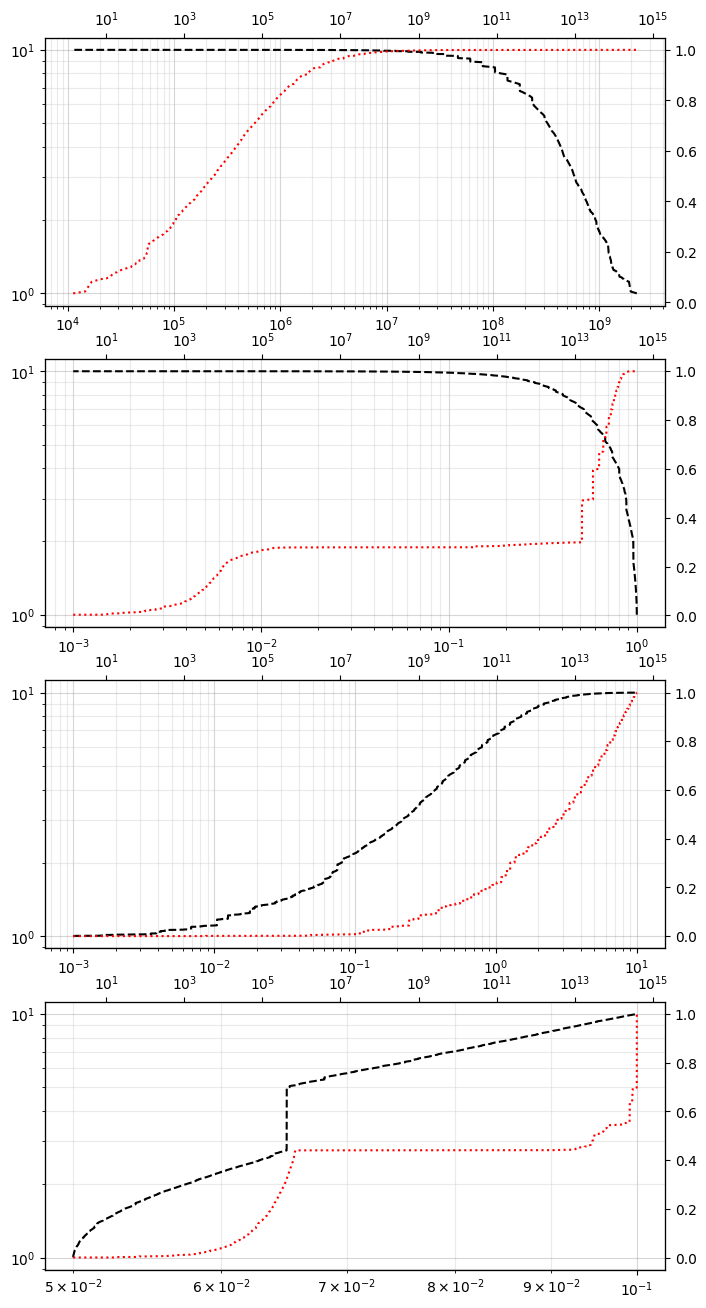

In [10]:
mc = utils.chirp_mass(*utils.m1m2_from_mtmr(vals[0], vals[1]))
rz = vals[2]
fo = vals[3]
frst = utils.frst_from_fobs(fo, rz)
dc = cosmo.comoving_distance(rz).cgs.value
hs = utils.gw_strain_source(mc, dc, frst/2.0)

cycles = 1.0 / np.diff(np.log(fextr))[0]
ww = weights * cycles
# gwb = np.sqrt(np.sum(ww * (hs ** 2)))

nv = len(vals)
fig, axes = plot.figax(figsize=[8, 4*nv], nrows=nv)

units = [MSOL, 1.0, 1.0, 1/YR]
reverse = [True, True, False, False]

for ii, (vv, ax) in enumerate(zip(vals, axes)):
    idx = np.argsort(vv)
    if reverse[ii]:
        idx = idx[::-1]
    # idx = idx[::-1]
    xx = vv[idx] / units[ii]
    gwb = np.sqrt(np.cumsum(ww[idx] * hs[idx]**2))
    gwb = gwb / gwb[-1]
    # ax.plot(xx, gwb)
    tw = ax.twinx()
    gwb = gwb / gwb[-1]
    # gwb = 1 - gwb
    tw.plot(xx, gwb, 'k--')
    
    tw = tw.twiny(); tw.set(xscale='log')
    tw.plot(np.cumsum(ww[idx]), gwb, 'r:')
    
plt.show()


In [11]:
sel = (vals[0] > 3e7*MSOL) & (vals[1] >= 0.05) & (rz <= 5.0)
tot = np.sqrt(np.sum(ww * hs**2))
cut = np.sqrt(np.sum(ww[sel] * hs[sel]**2))
print(f"{cut=:.4e}, {tot=:.4e}, {cut/tot=:.4e}")
print(f"{np.sum(ww[sel]):.4e}, {ww.sum():.4e}, {ww[sel].sum()/ww.sum():.4e}")

cut=1.4532e-15, tot=1.4861e-15, cut/tot=9.7784e-01
2.4541e+07, 3.8551e+14, 6.3659e-08


# Sample (Discretize) Assuming GW-Driven Evolution

In [15]:
vals, weights, edges, dens, mass = holo.sam.sample_sam_with_hardening(sam, hard, fobs_orb=fobs, sample_threshold=1e2, poisson_inside=True, poisson_outside=True)

ValueError: lam value too large

In [16]:
hs, fo = holo.gravwaves._strains_from_samples(vals)

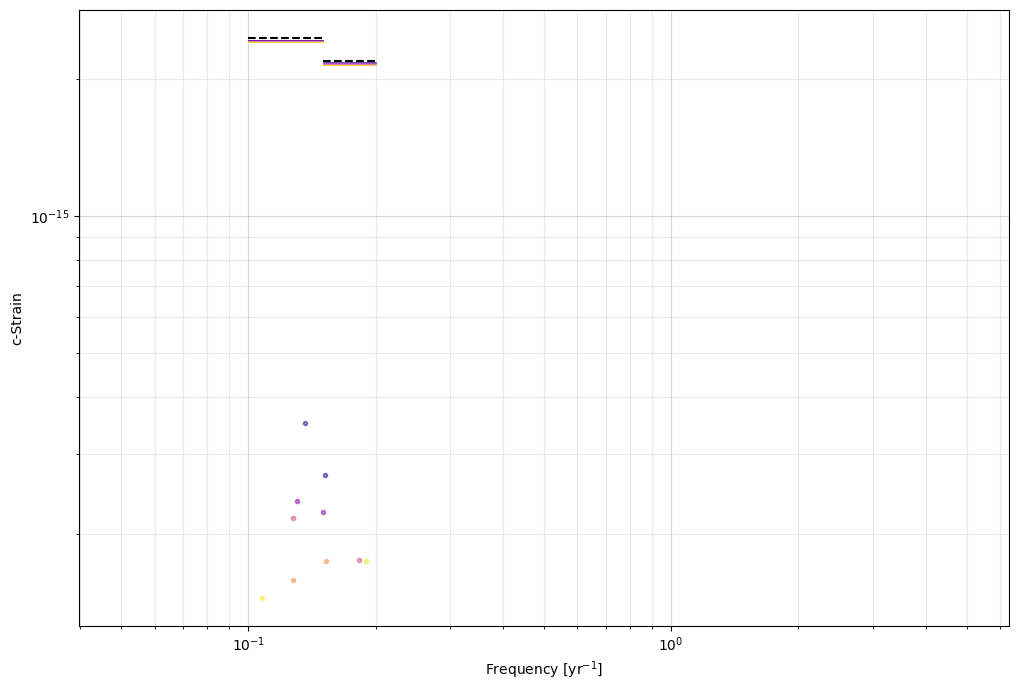

In [17]:
nloud = 5
colors = plot._get_cmap('plasma')(np.linspace(0.05, 0.95, nloud))# print(colors)

fig, ax = plot.figax(figsize=[12, 8], xlabel='Frequency [yr$^{-1}$]', ylabel='c-Strain')
for ii in range(fobs.size-1):
    # if ii < 10 or ii > 16:
    #     continue
    
    fextr = [fobs[ii+jj] for jj in range(2)]
    fextr = np.asarray(fextr)
    cycles = 1.0 / np.diff(np.log(fextr))[0]

    idx = (fextr[0] <= fo) & (fo < fextr[1])
    hs_bin = hs[idx]
    fo_bin = fo[idx]    
    ww_bin = weights[idx]
    ww = ww_bin * cycles

    tot = np.sqrt(np.sum(ww * hs_bin**2))
    ax.plot(fextr*YR, tot * np.ones_like(fextr), 'k--')

    idx = np.argsort(hs_bin)[::-1]
    if any(ww_bin[idx[:nloud]] > 1):
        raise
    
    for jj, cc in enumerate(colors):
        if jj >= len(idx):
            break
        hi = idx[jj]
        lo = idx[jj+1:]
        gw_hi = np.sqrt(np.sum(ww[hi] * hs_bin[hi]**2))
        gw_lo = np.sqrt(np.sum(ww[lo] * hs_bin[lo]**2))

        fave = np.average(fo_bin[hi], weights=hs_bin[hi])
        ax.plot(fextr*YR, gw_lo * np.ones_like(fextr), color=cc, lw=0.5)
        ax.scatter(fave*YR, gw_hi, marker='.', color=cc, alpha=0.5)

plt.show()

In [ ]:
use_fobs = fobs
use_fobs = kale.utils.subdivide(fobs, 4)
print(fobs.size, use_fobs.size)
vals, weights, edges, dens = holo.sam.sample_sam_with_hardening(
        sam, holo.evolution.Hard_GW, fobs=use_fobs,
        sample_threshold=10.0, cut_below_mass=1e7, limit_merger_time=4*GYR,
)
print(weights.size)

In [ ]:
# dnum = sam._dnum
# print(dnum.shape)
# test = np.sum(dnum, axis=(0, 1, 2))
# print(test.shape)
# fig, ax = plot.figax()
# xx = sam._edges[-1]
# ax.plot(xx, test)
# plt.show()

log_edges = sam._log_edges
dnum = sam._dnum
axes = (1, 2)
log_edges = [log_edges[ii] for ii in range(len(log_edges)) if ii not in axes]
dnum = dnum.sum(axis=axes)

dnum = dnum[22:30, :7]
log_edges = [log_edges[0][22:30], log_edges[1][:7]]
print(dnum.shape)

fname = "kalepy_sample_outliers_error.npz"
np.savez(fname, dens=dnum, edges=log_edges)
print(f"Saved error example data to '{fname}'")

vals, weights = kale.sample_outliers(log_edges, dnum, 10.0)
fo = np.e ** vals[-1]
# ee = sam._edges[-1]
ee = np.e ** log_edges[-1]

fig, ax = plot.figax()
xx = ee
xx = kale.utils.subdivide(ee, 2, log=True)
print(weights.size, weights.sum(), weights.mean())
idx = ()
# idx = (weights == 1.0)
ax.hist(fo[idx], bins=xx, weights=weights[idx])

plt.show()

In [ ]:
fig, ax = plot.figax()
_ee = edges[-1] * YR
fo = vals[-1] * YR
# print(utils.stats(fo))
ee = kale.utils.subdivide(_ee, 3, log=True)
idx = ()
# idx = (weights != 1.0)
# idx = (weights == 1.0)
ax.hist(fo[idx], bins=ee, weights=weights[idx])
for e in _ee:
    ax.axvline(e, color='0.5', ls='--', alpha=0.2, zorder=1)
for e in ee:
    ax.axvline(e, color='r', ls='--', alpha=0.2, zorder=1)
plt.show()

In [ ]:
breaker()

# Calculate GWs from Samples

In [ ]:
gwf_freqs, gwf, gwb = holo.sam._gws_from_samples(vals, weights, fobs)

In [ ]:
# gwb_rough = sam.gwb(fobs, realize=33)
# gwb_smooth = sam.gwb(fobs, realize=False)

In [ ]:
fig, ax = plot.figax()

xx = kale.utils.midpoints(fobs) * YR   # [1/sec] ==> [1/yr]

amp = 10e-16
yy = amp * np.power(xx, -2/3)
ax.plot(xx, yy, 'k--', alpha=0.25)

# ff = np.sqrt(xx / np.diff(fobs*YR))
ff = 1.0

ax.plot(xx, gwb*ff, 'k-')

idx = (gwf > gwb)
xx = gwf_freqs * YR   # [1/sec] ==> [1/yr]
ax.scatter(xx[idx], (gwf*ff)[idx], color='r', s=20, alpha=0.5)
ax.scatter(xx[~idx], (gwf*ff)[~idx], edgecolor='r', facecolor='none', s=20, alpha=0.5)

# ax.plot(fobs*YR, gwb_smooth, 'b--')
# ax.plot(fobs*YR, np.median(gwb_rough, axis=-1), 'b:')
# ax.fill_between(fobs*YR, *np.percentile(gwb_rough, [25, 75], axis=-1), color='b', alpha=0.25)

plt.show()

# Use realistic hardening rate to sample population

In [ ]:
hard = holo.evolution.Fixed_Time.from_sam(sam, 2.0*GYR)

# =========== TESTING =============

In [ ]:
fname = "/Users/lzkelley/Programs/nanograv/holodeck/pop-sam_v0.2_b54efb6__d20.0_c0.100_sh0050_st+2.000/0000.npz"

data = np.load(fname)

In [ ]:
data['redz'].shape

In [ ]:
nloud = 5
weights = data['weights']
hs, fo = holo.sam._strains_from_samples([data[kk] for kk in ['mtot', 'mrat', 'redz', 'fobs']])
colors = plot._get_cmap('plasma')(np.linspace(0.1, 0.9, nloud))

fig, ax = plot.figax(figsize=[12, 8], xlabel='Frequency [yr$^{-1}$]', ylabel='c-Strain')
for ii in utils.tqdm(range(fobs.size-1)):
    fextr = [fobs[ii+jj] for jj in range(2)]
    fextr = np.asarray(fextr)
    cycles = 1.0 / np.diff(np.log(fextr))[0]

    idx = (fextr[0] <= fo) & (fo < fextr[1])
    hs_bin = hs[idx]
    fo_bin = fo[idx]    
    ww_bin = weights[idx]
    ww = ww_bin * cycles

    tot = np.sqrt(np.sum(ww * hs_bin**2))
    ax.plot(fextr*YR, tot * np.ones_like(fextr), 'k--')

    idx = np.argsort(hs_bin)[::-1]
    if any(ww_bin[idx[:nloud]] > 1):
        raise
    
    for jj, cc in enumerate(colors):
        if jj > len(idx):
            break
        hi = idx[jj]
        lo = idx[jj+1:]
        gw_hi = np.sqrt(np.sum(ww[hi] * hs_bin[hi]**2))
        gw_lo = np.sqrt(np.sum(ww[lo] * hs_bin[lo]**2))

        fave = np.average(fo_bin[hi], weights=hs_bin[hi])
        ax.plot(fextr*YR, gw_lo * np.ones_like(fextr), color=cc, lw=0.5)
        ax.scatter(fave*YR, gw_hi, marker='.', color=cc, alpha=0.5)

plt.show()